In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import dgl
from sklearn.preprocessing import LabelEncoder, StandardScaler
import h5py
import networkx as nx 
from torch_geometric.utils.convert import from_dgl
import dask.dataframe as dd


/home/taznk/COMP4003/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Setup

In [13]:
dtypes = {
    'IPV4_SRC_ADDR': 'object',	                # IPv4 source address
    'IPV4_DST_ADDR': 'object',	                # IPv4 destination address
    'L4_SRC_PORT': 'object',	                # IPv4 source port number
    'L4_DST_PORT': 'object',	                # IPv4 destination port number

    'PROTOCOL': 'int32',	                # IP protocol identifier byte
    'L7_PROTO': 'category',	                # Layer 7 protocol (numeric)
    'IN_BYTES': 'int32',	                # Incoming number of bytes
    'OUT_BYTES': 'int32',	                # Outgoing number of bytes
    'IN_PKTS': 'int32',	                # Incoming number of packets
    'OUT_PKTS': 'int32',	                # Outgoing number of packets
    'FLOW_DURATION_MILLISECONDS': 'float32',	                # Flow duration in milliseconds
    'TCP_FLAGS': 'int32',	                # Cumulative of all TCP flags
    'CLIENT_TCP_FLAGS': 'int32',	                # Cumulative of all client TCP flags
    'SERVER_TCP_FLAGS': 'int32',	                # Cumulative of all server TCP flags
    'DURATION_IN': 'float32',	                # Client to Server stream duration (msec)
    'DURATION_OUT': 'float32',	                # Client to Server stream duration (msec)
    'MIN_TTL': 'float32',	                # Min flow TTL
    'MAX_TTL': 'float32',	                # Max flow TTL
    'LONGEST_FLOW_PKT': 'int32',	            # Longest packet (bytes) of the flow
    'SHORTEST_FLOW_PKT': 'int32',	            # Shortest packet (bytes) of the flow
    'MIN_IP_PKT_LEN': 'int32',	            # Len of the smallest flow IP packet observed
    'MAX_IP_PKT_LEN': 'int32',	            # Len of the largest flow IP packet observed
    'SRC_TO_DST_SECOND_BYTES': 'float32',	            # Src to dst Bytes/sec
    'DST_TO_SRC_SECOND_BYTES': 'float32',	            # Dst to src Bytes/sec
    'RETRANSMITTED_IN_BYTES': 'int32',	            # Number of retransmitted TCP flow bytes (src->dst)
    'RETRANSMITTED_IN_PKTS': 'int32',	            # Number of retransmitted TCP flow packets (src-...
    'RETRANSMITTED_OUT_BYTES': 'int32',         # 	Number of retransmitted TCP flow bytes (dst->src)
    'RETRANSMITTED_OUT_PKTS': 'int32',	            # Number of retransmitted TCP flow packets (dst-...
    'SRC_TO_DST_AVG_THROUGHPUT': 'float32',	            # Src to dst average thpt (bps)
    'DST_TO_SRC_AVG_THROUGHPUT': 'float32',         # 	Dst to src average thpt (bps)
    'NUM_PKTS_UP_TO_128_BYTES': 'int32',	            # Packets whose IP size <= 128
    'NUM_PKTS_128_TO_256_BYTES': 'int32',	            # Packets whose IP size > 128 and <= 256
    'NUM_PKTS_256_TO_512_BYTES': 'int32',	            # Packets whose IP size > 256 and <= 512
    'NUM_PKTS_512_TO_1024_BYTES': 'int32',	            # Packets whose IP size > 512 and <= 1024
    'NUM_PKTS_1024_TO_1514_BYTES': 'int32',	            # Packets whose IP size >��1024 and <= 1514
    'TCP_WIN_MAX_IN': 'int32',	            # Max TCP Window (src->dst)
    'TCP_WIN_MAX_OUT': 'int32',         # 	Max TCP Window (dst->src)

    # ?
    'ICMP_TYPE': 'category',	            # ICMP Type * 256 + ICMP code
    'ICMP_IPV4_TYPE': 'category',	            # ICMP Type

    'DNS_QUERY_ID': 'float32',	            #    DNS query transaction Id
    'DNS_QUERY_TYPE': 'category',	        #            DNS query type (e.g. 1=A, 2=NS..)
    'DNS_TTL_ANSWER': 'float32',	        #    TTL of the first A record (if any)
    'FTP_COMMAND_RET_CODE': 'category',	    #    FTP client command return code
    'FLOW_START_MILLISECONDS': 'float32',	#        Flow start timestamp in milliseconds
    'FLOW_END_MILLISECONDS': 'float32',	    #        Flow end timestamp in milliseconds
    'SRC_TO_DST_IAT_MIN': 'float32',	    #    Minimum Inter-Packet Arrval Time (src->dst)
    'SRC_TO_DST_IAT_MAX': 'float32',	    #        Maximum Inter-Packet Arrval Time (src->dst)
    'SRC_TO_DST_IAT_AVG': 'float32',	    #        Average Inter-Packet Arrval Time (src->dst)
    'SRC_TO_DST_IAT_STDDEV': 'float32',	    #        Sandard Deviaion Inter-Packet Arrval Time (src...
    'DST_TO_SRC_IAT_MIN': 'float32',	    #        Minimum Inter-Packet Arrval Time (dst > src)
    'DST_TO_SRC_IAT_MAX': 'float32',	    #        Minimum Inter-Packet Arrval Time (dst > src)
    'DST_TO_SRC_IAT_AVG': 'float32',	    #        Minimum Inter-Packet Arrval Time (dst > src)
    'DST_TO_SRC_IAT_STDDEV': 'float32',	    #        Minimum Inter-Packet Arrval Time (dst > src)
    
}

In [3]:
df = pd.read_csv('raw/NF-BoT-IoT-v3.csv', dtype=dtypes)
df[:2]

,FLOW_START_MILLISECONDS,FLOW_END_MILLISECONDS,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,...,SRC_TO_DST_IAT_MIN,SRC_TO_DST_IAT_MAX,SRC_TO_DST_IAT_AVG,SRC_TO_DST_IAT_STDDEV,DST_TO_SRC_IAT_MIN,DST_TO_SRC_IAT_MAX,DST_TO_SRC_IAT_AVG,DST_TO_SRC_IAT_STDDEV,Label,Attack
0,1.528104e+12,1.528104e+12,192.168.100.7,365,192.168.100.3,565,17,0.0,238142,5177,...,1.0,30.0,22.0,4.0,0.0,0.0,0.0,0.0,0,Benign
1,1.528104e+12,1.528104e+12,192.168.100.46,3456,192.168.100.5,80,17,0.0,9015892,9630,...,1.0,28.0,12.0,1.0,1.0,30.0,12.0,2.0,0,Benign


In [4]:
data = df
data = data.drop("Label", axis=1)  # for binary only

In [5]:
data.Attack.unique()

array(['Benign', 'DDoS', 'DoS', 'Reconnaissance', 'Theft'], dtype=object)

In [6]:
benign = len(data[data.Attack == 'Benign'])
benign

51989

In [7]:
# 1:10 mal:benign ratio

target = benign // 10
df_reduced = pd.DataFrame()

for a, group in data.groupby('Attack'):
    l = len(group)
    group.reset_index()
    print(a, l, len(group.iloc[:target])) 
    df_reduced = pd.concat((df_reduced, group.iloc[:target]))
    if a == 'Benign':
        df_reduced = pd.concat((df_reduced, group))
    

Benign 51989 5198
DDoS 7150882 5198
DoS 8034190 5198
Reconnaissance 1695132 5198
Theft 1615 1615


In [8]:
len(df_reduced), len(data)

(74396, 16933808)

In [9]:
del data

In [10]:
df_reduced.to_csv('interm/BoT-IoT_reduced.csv', index=False)

In [11]:
df_reduced = pd.read_csv('interm/BoT-IoT_reduced.csv')

In [14]:
# paper used labelencoding for all categories
pk = ['IPV4_SRC_ADDR','IPV4_DST_ADDR']
categorical = [
    c for c, dtype in dtypes.items() 
    if dtype=='category' and dtype not in pk
] + ['Attack']

encoders = {}
for c in categorical:
    le = LabelEncoder()
    df_reduced[c] = le.fit_transform(df_reduced[c].astype(str))
    encoders[c] = le

In [15]:

from sklearn.preprocessing import StandardScaler

# and standradization for the rest
pk = ['IPV4_DST_ADDR', 'IPV4_SRC_ADDR']
numerical = [c for c in df_reduced.columns if (c not in categorical + pk)]
df_reduced[numerical] = df_reduced[numerical].astype('float32')
df_reduced[numerical] = df_reduced[numerical].replace([np.inf, -np.inf], np.nan)
df_reduced[numerical] = df_reduced[numerical].fillna(df_reduced[numerical].mean())
    
scaler = StandardScaler()
df_reduced[numerical] = scaler.fit_transform(df_reduced[numerical])

In [16]:
data = df_reduced

data['src'] = data['IPV4_SRC_ADDR'].astype(str) + ':' + data['L4_SRC_PORT'].astype(str)
data['dst'] = data['IPV4_DST_ADDR'].astype(str) + ':' + data['L4_DST_PORT'].astype(str)
data[:1]

,FLOW_START_MILLISECONDS,FLOW_END_MILLISECONDS,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,...,SRC_TO_DST_IAT_MAX,SRC_TO_DST_IAT_AVG,SRC_TO_DST_IAT_STDDEV,DST_TO_SRC_IAT_MIN,DST_TO_SRC_IAT_MAX,DST_TO_SRC_IAT_AVG,DST_TO_SRC_IAT_STDDEV,Attack,src,dst
0,1.380989,1.38113,192.168.100.7,-1.045265,192.168.100.3,-0.441081,1.715256,0,-0.019245,4.235564,...,-0.336749,-0.37095,-0.309771,-0.222788,-0.29177,-0.232264,-0.311674,0,192.168.100.7:-1.0452653,192.168.100.3:-0.4410811


In [17]:
data.drop(['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'L4_SRC_PORT', 'L4_DST_PORT'], axis=1, inplace=True)
data[:1]

,FLOW_START_MILLISECONDS,FLOW_END_MILLISECONDS,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,...,SRC_TO_DST_IAT_MAX,SRC_TO_DST_IAT_AVG,SRC_TO_DST_IAT_STDDEV,DST_TO_SRC_IAT_MIN,DST_TO_SRC_IAT_MAX,DST_TO_SRC_IAT_AVG,DST_TO_SRC_IAT_STDDEV,Attack,src,dst
0,1.380989,1.38113,1.715256,0,-0.019245,4.235564,-0.071896,-0.156309,-1.470286,-0.676841,...,-0.336749,-0.37095,-0.309771,-0.222788,-0.29177,-0.232264,-0.311674,0,192.168.100.7:-1.0452653,192.168.100.3:-0.4410811


In [18]:
attrs = [c for c in df_reduced.columns if c not in ("src", "dst", "Attack")]
data['x'] = data[attrs].values.tolist()
data['x']

0        [1.3809889554977417, 1.3811296224594116, 1.715...
1        [1.3809889554977417, 1.3811296224594116, 1.715...
2        [1.3809889554977417, 1.3811296224594116, -0.50...
3        [1.3809889554977417, 1.3811296224594116, 1.715...
4        [1.3809889554977417, 1.3811296224594116, -0.50...
                               ...                        
74391    [3.1985068321228027, 3.1984338760375977, -0.50...
74392    [3.1985068321228027, 3.1984338760375977, -0.50...
74393    [3.1985068321228027, 3.1984338760375977, -0.50...
74394    [3.1985068321228027, 3.1984338760375977, -0.50...
74395    [3.1985068321228027, 3.1984338760375977, -0.50...
Name: x, Length: 74396, dtype: object

### Graph encode

In [19]:

# edge features, will be node features (x)
data['x'] = data['x'].apply(lambda x: np.array(x, dtype=np.float32))

G = nx.from_pandas_edgelist(data, source='src', 
                            target='dst', 
                            edge_attr=['x', 'Attack'], 
                            create_using=nx.MultiGraph())

G = G.to_directed()
G.number_of_edges(), G.number_of_nodes()
      

(148792, 55473)

In [20]:
len(data)

74396

In [21]:
G = dgl.from_networkx(G, edge_attrs=['x', 'Attack'])
# G = G.line_graph(shared=True)
G.number_of_edges(), G.number_of_nodes()

(148792, 55473)

In [22]:
import pickle 

with open('interm/BoT-IoT_reduced_graph.pkl', 'wb') as f:
    pickle.dump(G, f)

### Train

In [46]:
import pickle 

with open('interm/BoT-IoT_reduced_graph.pkl', 'rb') as f:
    G = pickle.load(f)

/home/taznk/COMP4003/venv/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [9]:
import torch as th

G.ndata['x'] = th.ones(G.number_of_nodes(), 49)

# Egraphsage paper code requirements
G.ndata['h'] = G.ndata['x']
G.edata['h'] = G.edata['x']
G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1,G.ndata['h'].shape[1]))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1,G.edata['h'].shape[1]))

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [06:21<00:00,  2.62it/s]


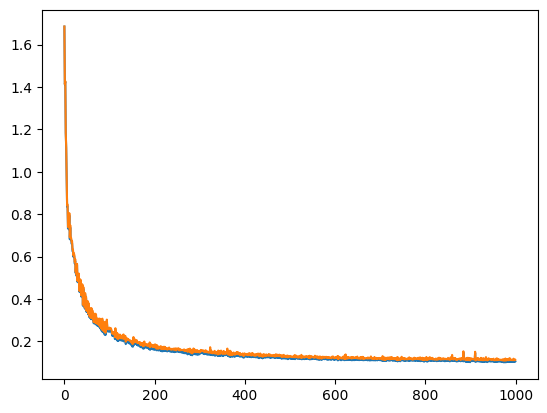

In [40]:
from EGraphSAGE_papercode import Model
from torch.functional import F

from tqdm import tqdm
import matplotlib.pyplot as plt
from torch import nn

model = Model(
    ndim_in=49,
    ndim_out=128, 
    edim=49,    
    activation=F.relu,
    dropout=0.2,
    classes=5
)

cr = nn.CrossEntropyLoss()

# test/train masks
size = G.num_edges()
indices = np.arange(size)
np.random.shuffle(indices)
train_cutoff = int(size * 0.8)
train_idx = th.tensor(indices[:train_cutoff], dtype=th.long)
test_idx = th.tensor(indices[train_cutoff:], dtype=th.long)


losses, test_losses = [], []
for epoch in tqdm(range(1000)):
    
    optimizer = th.optim.Adam(model.parameters())
    model.train()

    labels =  G.edata['Attack']
    # G = from_dgl(G)

    optimizer.zero_grad()
    pred = model(G, G.ndata['h'], G.edata['h'])

    loss = cr(pred[train_idx, :], labels[train_idx])
    loss.backward()
    
    optimizer.step()
    test_loss = cr(pred[test_idx, :], labels[test_idx])

    losses.append(loss.item())
    test_losses.append(test_loss.item())
    
    
plt.plot(losses)
plt.plot(test_losses)

In [44]:
from sklearn.metrics import classification_report
import torch.nn.functional as F

model.eval()

with th.no_grad():
    pred_logits = model(G, G.ndata['h'], G.edata['h']) 
    y_pred = pred_logits[test_idx].argmax(dim=1).cpu().numpy()
    y_true = labels[test_idx].cpu().numpy()


report = classification_report(
    y_true, y_pred,
    labels=[0, 1, 2, 3, 4],
    target_names=[f'Class {i}' for i in range(5)],
    digits=4
)

print(report)

              precision    recall  f1-score   support

     Class 0     0.9922    0.9997    0.9959     22799
     Class 1     0.6368    0.9073    0.7484      2103
     Class 2     0.8418    0.4841    0.6147      2111
     Class 3     0.9958    0.9169    0.9547      2081
     Class 4     0.9985    0.9940    0.9962       665

    accuracy                         0.9507     29759
   macro avg     0.8930    0.8604    0.8620     29759
weighted avg     0.9568    0.9507    0.9485     29759



In [50]:
th.save(model.state_dict(), 'interm/EGraphSAGE_BoTIoT.pth')

### Explain

In [4]:
import pickle 
import torch as th

with open('interm/BoT-IoT_reduced_graph.pkl', 'rb') as f:
    G = pickle.load(f)
    
G.ndata['x'] = th.ones(G.number_of_nodes(), 49)

# Egraphsage paper code requirements
G.ndata['h'] = G.ndata['x']
G.edata['h'] = G.edata['x']
G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1,G.ndata['h'].shape[1]))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1,G.edata['h'].shape[1]))

/home/taznk/COMP4003/venv/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [ ]:
from torch_geometric.explain import Explainer, GNNExplainer
from EGraphSAGE_papercode import Model, PyGWrapper
import torch.nn.functional as F

model = Model(ndim_in=49, ndim_out=128,  edim=49,     
              activation=F.relu, dropout=0.2, classes=5)
model.load_state_dict(th.load('interm/EGraphSAGE_BoTIoT.pth'))

PyGModel = PyGWrapper(model)
PyGModel.eval()


explainer = GNNExplainer(epochs=200)

G_PyG = from_dgl(G)
edge_attr = G.edata['h']
node_attr = G.ndata['h']
node_index = int(G_PyG.edge_index[0, 0])

h = PyGModel(G_PyG.x, G_PyG.edge_index, edge_attr)


explanation = explainer.explain_node(
    node_idx=node_index,
    x=G_PyG.x,
    edge_index=G_PyG.edge_index,
    edge_attr=edge_attr
)

explainer.visualize_subgraph(node_index, G_PyG.edge_index, explanation)

/tmp/ipykernel_2812/1071574732.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(th.load('interm/EGraphSAGE_BoTIoT.pth'))


TypeError: GNNExplainer.__init__() got multiple values for argument 'epochs'

In [ ]:
GNNExplainer(epochs=200)